# Comparison of PCA+DBSCAN to UMAP

In [1]:
import pandas as pd
import numpy as np
import pickle
import math
import re
import os

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import seaborn as sns

In [ ]:
import spacy
import re
nlp = spacy.load("en_core_web_lg")

In [ ]:
try:
    import umap
except ModuleNotFoundError:
    !pip install umap-learn
    import umap

### Process Tutorial Data 

For demonstration purposes, here we pick up with Part 2 of the ['Clustering with sklearn'](https://programminghistorian.org/en/lessons/clustering-with-scikit-learn-in-python#1-loading-the-dataset--exploratory-data-analysis) tutorial on The Programming Historian.

In [2]:
ddf = pd.read_csv('https://raw.githubusercontent.com/programminghistorian/jekyll/gh-pages/assets/clustering-with-scikit-learn-in-python/data/RELIGION_abstracts.csv', 
                 usecols=['title','abstract','link','volume'])
ddf.head()

,title,abstract,link,volume
0,Norwegian Muslims denouncing terrorism: beyond...,"In contemporary European societies, Muslims ar...",https://www.tandfonline.com/doi/full/10.1080/0...,https://www.tandfonline.com/loi/rrel20?treeId=...
1,A comparative analysis of three Sunni Muslim o...,The distinction between ‘moderate’ and ‘radica...,https://www.tandfonline.com/doi/full/10.1080/0...,https://www.tandfonline.com/loi/rrel20?treeId=...
2,Musical negotiations of a ‘moderate’ versus a ...,"This article explores how in Morocco, music is...",https://www.tandfonline.com/doi/full/10.1080/0...,https://www.tandfonline.com/loi/rrel20?treeId=...
3,Aesthetics of authority: ‘Islam Nusantara’ and...,"In Indonesia, Islamic ‘counter-terror culture’...",https://www.tandfonline.com/doi/full/10.1080/0...,https://www.tandfonline.com/loi/rrel20?treeId=...
4,Countering ‘Islamic’ violent extremism? The im...,This article explores how Muslim-led civil soc...,https://www.tandfonline.com/doi/full/10.1080/0...,https://www.tandfonline.com/loi/rrel20?treeId=...


In [3]:
ddf.describe()

,title,abstract,link,volume
count,701,701,701,701
unique,701,701,701,40
top,Norwegian Muslims denouncing terrorism: beyond...,"In contemporary European societies, Muslims ar...",https://www.tandfonline.com/doi/full/10.1080/0...,https://www.tandfonline.com/loi/rrel20?treeId=...
freq,1,1,1,41


In [4]:
def lemmatizeAbstracts(x):
        doc = nlp(x)
        new_text = []
        for token in doc:
            new_text.append(token.lemma_)
        text_string = " ".join(new_text)
        # getting rid of non-word characters
        text_string = re.sub(r"[^\w\s]+", "", text_string)
        text_string = re.sub(r"\s{2,}", " ", text_string)
        return text_string

ddf["abstract_lemma"] = ddf.abstract.apply(lemmatizeAbstracts)

In [5]:
tfidf = TfidfVectorizer(stop_words="english", ngram_range=(1,2), max_features=250, strip_accents="unicode", min_df=10, max_df=200)
tfidf_religion_array = tfidf.fit_transform(ddf["abstract_lemma"])
df_abstracts_tfidf = pd.DataFrame(tfidf_religion_array.toarray(), index=ddf.index, columns=tfidf.get_feature_names_out())
df_abstracts_tfidf.describe()

,academic,account,activity,address,african,agency,aim,allow,american,analyse,...,use,value,various,view,way,western,woman,work,world,year
count,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,...,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000
mean,0.017363,0.017717,0.010672,0.011085,0.011509,0.009045,0.010500,0.009290,0.015331,0.011879,...,0.032995,0.014285,0.013606,0.021305,0.027716,0.021142,0.018380,0.028023,0.028909,0.014592
std,0.063741,0.067549,0.051874,0.047177,0.067058,0.053898,0.045405,0.043054,0.068593,0.051070,...,0.073718,0.061453,0.052510,0.064549,0.062582,0.077795,0.095341,0.074759,0.073715,0.052934
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.493959,0.709610,0.501811,0.360210,0.737125,0.658109,0.386911,0.409185,0.624589,0.455129,...,0.579163,0.828967,0.530411,0.515540,0.364839,0.724452,0.941381,0.604459,0.492094,0.365751


### PCA

In [6]:
# using PCA to reduce the dimensionality
pca = PCA(n_components=10, whiten=False, random_state=42)
abstracts_pca = pca.fit_transform(df_abstracts_tfidf)
df_abstracts_pca = pd.DataFrame(data=abstracts_pca)
df_abstracts_pca.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.091122,-0.128981,-0.002269,0.164550,0.161729,0.094335,-0.041135,-0.062922,0.255918,-0.028102
1,-0.102431,-0.181978,-0.038363,0.232737,0.206442,0.109074,-0.046323,-0.101923,0.278467,-0.095652
2,-0.138301,-0.115936,0.036626,0.163313,0.345457,0.123710,-0.025124,-0.105670,0.293439,-0.101880
3,-0.114635,-0.134628,-0.020789,0.201942,0.245130,0.145807,-0.050429,-0.092156,0.284293,-0.063330
4,-0.014644,-0.144262,0.043087,0.259449,0.187591,0.099419,0.015231,-0.107935,0.220821,0.001087


Here's the issue with PCA:

In [7]:
print(f"Total explained variance is {np.sum(pca.explained_variance_)*100:0.2f}% with first eigenvector explaining {pca.explained_variance_[0]*100:0.2f}%")

Total explained variance is 11.68% with first eigenvector explaining 1.69%


In [8]:
# I cannot reproduce the 4-cluster result using an eps of 0.2
dbscan = DBSCAN(eps=0.18, metric="euclidean")
dbscan_labels = dbscan.fit_predict(df_abstracts_pca)
df_abstracts_dbscan = ddf.copy()
df_abstracts_dbscan['cluster'] = dbscan_labels
df_abstracts_dbscan.cluster.value_counts()

 1    398
-1    272
 0     11
 2      8
 3      7
 4      5
Name: cluster, dtype: int64

### UMAP

In [9]:
reducer = umap.UMAP(
            n_neighbors=8,
            min_dist=0.02,
            n_components=2,
            random_state=42)
    
# Basically reduces our 300 feature vectors for each thesis, down to n dimensions
X_embedded = reducer.fit_transform(df_abstracts_tfidf)
print(f"Resulting embedding is: {X_embedded.shape[0]} rows by {X_embedded.shape[1]} columns.")

Resulting embedding is: 701 rows by 2 columns.


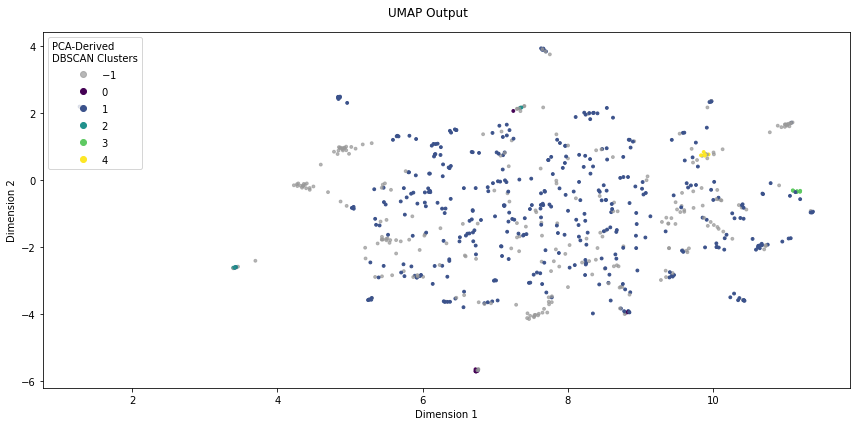

In [12]:
# Grab the DBSCAN assignments based on the 
# PCA-decomposed data
f,axs = plt.subplots(1,1,figsize=(12,6))
f.suptitle("UMAP Output") 

if isinstance(axs, np.ndarray):
    axs = axs.reshape(-1)
else:
    axs = [axs]

newcolors = np.insert(cm.get_cmap('viridis', 5).colors, 0, [0.6, 0.6, 0.6, 0.7], axis=0)
newcmp = ListedColormap(newcolors)
    
for i, ax in enumerate(axs):
    ax.set_xlabel(f"Dimension {i*2+1}")
    ax.set_ylabel(f"Dimension {i*2+2}")
    sctr = ax.scatter(x=X_embedded[:,i*2], y=X_embedded[:,i*2+1], s=8, c=dbscan_labels, cmap=newcmp)
    ax.legend(*sctr.legend_elements(), loc='upper left', title='PCA-Derived\nDBSCAN Clusters')
    
f.tight_layout()
plt.savefig(os.path.join('sessions','UMAP_Output.png'), dpi=150)

In [14]:
fg_list = ['darkgrey','darkorange','lightblue','brown','red','green']
fp = os.path.join(os.sep,'Library','Font','Khula-Light.ttf')
bg = 'white'
wd = 50

def get_cloud(fg='black'):
    return WordCloud(
        #font_path=fp,
        max_words=wd,
        width=1000, height=1000,
        mode='RGBA',
        background_color=bg,
        color_func=lambda *args ,**kwargs: fg,
        stopwords=['religion','religious','article','study','paper'])

In [17]:
# From https://stackoverflow.com/a/45096142
stopwords=['religion','religious','article','study','paper','new','use','research','analysis']
stpw = text.ENGLISH_STOP_WORDS.union(stopwords)

vectorizer = TfidfVectorizer(stop_words=stpw)

num_clouds = df_abstracts_dbscan.cluster.max()+1 # Counts from zero

f,axs = plt.subplots(math.ceil(num_clouds/2),2,figsize=(12,12))

for i in range(0,max(dbscan_labels)+1):
    cldf = df_abstracts_dbscan[df_abstracts_dbscan.cluster==i]
    vecs = vectorizer.fit_transform(cldf.abstract_lemma)
    feature_names = vectorizer.get_feature_names_out()
    dense = vecs.todense()
    lst1 = dense.tolist()
    df = pd.DataFrame(lst1, columns=feature_names)
    wordcloud = get_cloud().generate_from_frequencies(df.T.sum(axis=1))
    axs.reshape(-1)[i].imshow(wordcloud, interpolation='bilinear')
    axs.reshape(-1)[i].axis('off')
    axs.reshape(-1)[i].set_title(f'Cluster {i}')

plt.axis('off')
plt.suptitle("Cluster TF/IDF")
plt.tight_layout(pad=1.35)

In [154]:
pd.set_option('display.max_colwidth',150)
for i in range(0,4):
    print(f"Cluster {i}")
    egs = dfl[dfl.cluster==i].title.sample(5, random_state=42)
    for e in egs:
        print(f"\tExample: {e[:75]}")
    print()
    

Cluster 0
	Example: The embodied text: Covenant and Torah
	Example: The body and the boundaries of Zoroastrian spirituality
	Example: Orisha Worship Communities: A Reconsideration of Organisational Structure
	Example: Seeking a ‘pure relationship'? Israeli Religious-Zionist singles looking fo
	Example: Counterintuitiveness as the hallmark of religiosity

Cluster 1
	Example: The current Conflict of the Faculties and the future of the study of religi
	Example: Aum Shinrikyō. Can Religious Studies Cope?
	Example: Why philosophy and history matter: A conversation with Ann Taves
	Example: The utterance from the east: The sense of hwt in psalms 52:4, 9; 91:3
	Example: Reconciling Nuers with Dinkas: A Girardian approach to conflict resolution

Cluster 2
	Example: Context‐bound Islamic theodicies: The tsunami as supernatural retribution v
	Example: Christmas fairs in Danish churches abroad: a resource mobilisation perspect
	Example: Esoteric currents as discursive complexes
	Example: The Easte